In [ ]:
# Importing all necessary libraries
%load_ext autoreload
%autoreload 2

# internal packages
import os
from collections import Counter, OrderedDict

# external packages
import torch
import torchvision
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
from sklearn.decomposition import PCA
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# util functions
from util.util import *

# dataset functions
from dataset import load_util

# autoencoder
from models.autoencoder.conv_ae import ConvAE
from models.simclr.simclr import *
from models.simclr.transforms import *
from models.rotnet.rotnet import *
from models.rotnet.IDEC import *

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

In [ ]:
print("Versions:")
print(f"torch: {torch.__version__}")
print(f"torchvision: {torchvision.__version__}")
print(f"numpy: {np.__version__}",)
print(f"scikit-learn: {sklearn.__version__}")

device = detect_device()
print("Using device: ", device)

In [ ]:
# specify learning params
batch_size = 128
learning_rate = 0.001
epochs = 150

# training

train = True

# load datasets and create dataloaders
data, testdata = load_util.load_cifar('./data', download=True, for_model='SimCLR')
data_percent = 0.4

### Clustering and PCA of the pretrained RotNet model 

In [ ]:
def encode_batchwise(dataloader, model, device, layer, flatten=False):
    """ Utility function for embedding the whole data set in a mini-batch fashion
    """
    embeddings = []
    labels = []
    for batch, blabels in dataloader:
        batch_data = batch.to(device)
        feats = model(batch_data, layer)
        if flatten:
            embeddings.append(feats.flatten(start_dim=1).detach().cpu())
        else:
            embeddings.append(feats.detach().cpu())
        labels = labels + blabels.tolist()
    return torch.cat(embeddings, dim=0).numpy(), labels

In [ ]:
test_data = load_util.load_custom_cifar('./data', download=False, train=False, data_percent=1.0, for_model='SimCLR')
testloader = torch.utils.data.DataLoader(test_data,
                                          batch_size=264,
                                          shuffle=True,
                                          drop_last=False)

In [ ]:
colors_classes = {i: color_class for i, color_class in zip(range(len(test_data.classes)), test_data.classes)}

In [84]:
# for i in range(3):
model = RotNet(num_classes=4)

state_dict = torch.load(f'trained_models/pretrained_RotNet_features.pth', map_location='cpu')
model.load_state_dict(state_dict)
model.to(device)

print(model.feat_block_names)

['conv1', 'conv2', 'conv3', 'pooling', 'features', 'classifier']


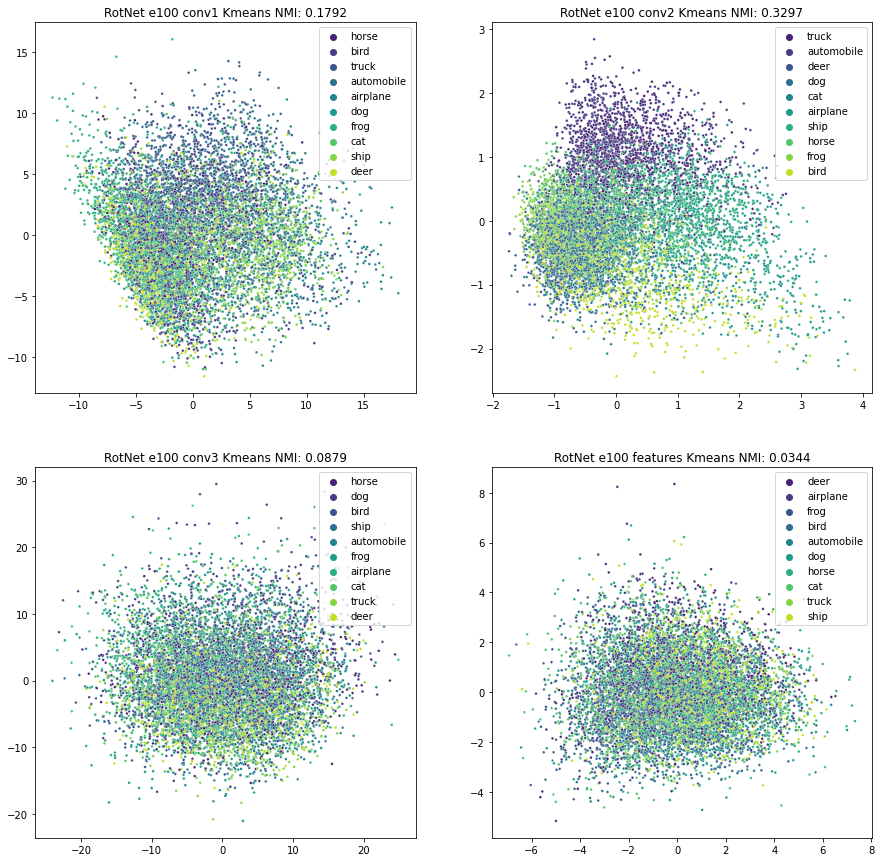

In [85]:
fig, axes = plt.subplots(2,2, figsize=(15,15))
axes = axes.flatten()
layers = ['conv1', 'conv2', 'conv3', 'features']

for i, layer in enumerate(layers):
    ver = f'RotNet e100 {layer}'
    embedded_data, labels = encode_batchwise(testloader, model, device, [layer], flatten=True)
    lable_classes=[colors_classes[l] for l in labels]

    n_clusters = len(set(labels))
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(embedded_data)
    nmi = normalized_mutual_info_score(labels, kmeans.labels_)

    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(embedded_data)

    axes[i].set_title(f'{ver} Kmeans NMI: {nmi:.4f}')
    sns.scatterplot(ax=axes[i], x=reduced_data[:,0], y=reduced_data[:,1], hue=lable_classes, s=7, palette='viridis')

### RotNet IDEC

In [ ]:
rotnet = IDEC(model=RotNet(num_classes=4))
state_dict = torch.load(f'trained_models/IDEC_RotNet_e100_features.pth', map_location=device)
rotnet.load_state_dict(state_dict)
rotnet.to(device)

fig, axes = plt.subplots(2,2, figsize=(15,15))
axes = axes.flatten()
layers = ['conv1', 'conv2', 'conv3', 'features']

for i, layer in enumerate(layers):
    ver = f'RotNet e100 {layer}'
    embedded_data, labels = encode_batchwise(testloader, model, device, [layer], flatten=True)
    lable_classes=[colors_classes[l] for l in labels]

    n_clusters = len(set(labels))
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(embedded_data)
    nmi = normalized_mutual_info_score(labels, kmeans.labels_)

    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(embedded_data)

    axes[i].set_title(f'{ver} Kmeans NMI: {nmi:.4f}')
    sns.scatterplot(ax=axes[i], x=reduced_data[:,0], y=reduced_data[:,1], hue=lable_classes, s=7, palette='viridis')

In [ ]:
vers = ['pretrained_RotNet_features', 'IDEC_RotNet_e100_features']
pcas = {}
nmis = {}

In [81]:
for ver in vers:
    print(ver)
    if 'IDEC' not in ver:
        rotnet = RotNet(num_classes=4)
    else:
        rotnet = IDEC(model=RotNet(num_classes=4), cluster_centers=torch.rand(size=(4, 10)))

    state_dict = torch.load(f'trained_models/{ver}.pth', map_location=device)
    rotnet.load_state_dict(state_dict)
    rotnet.to(device)
    
    if 'IDEC' not in ver:
        model = rotnet
    else:
        model = rotnet.model
    
    embedded_data, labels = model.encode_batchwise(testloader, device, ['features'], flatten=True)
    lable_classes=[colors_classes[l] for l in labels]

    n_clusters = len(set(labels))
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(embedded_data)
    nmis[ver] = normalized_mutual_info_score(labels, kmeans.labels_)

    pca = PCA(n_components=2)
    pcas[ver] = pca.fit_transform(embedded_data)

IDEC_RotNet_e100_features


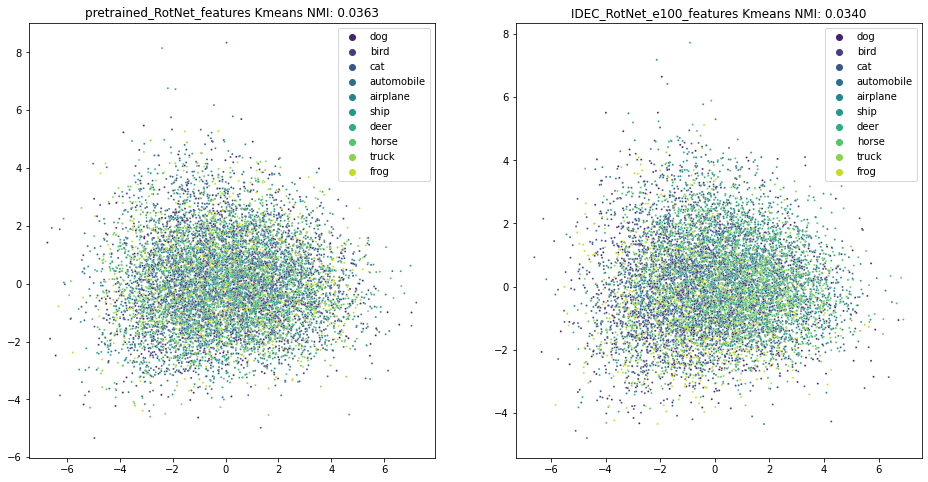

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes = axes.flatten()

for i, ver in enumerate(vers):
    axes[i].set_title(f'{ver} Kmeans NMI: {nmis[ver]:.4f}')
    sns.scatterplot(ax=axes[i], x=pcas[ver][:,0], y=pcas[ver][:,1], hue=lable_classes, s=4, palette='viridis')

As we have discussed last Friday, I have tried to add an additional linear layer with 10 output dimensions, but as we see, clustering based on features was not really successful. I have read the paper again and have noticed the following: they also pretrain the model to get relevant features, and then use the output from one of the inner convolutional layers (2d is the best) to train a classifier in a supervised way, so they use the true labels. 

So I kind of have a problem here: I either need to use true labels to continue training with cross entropy, because cross entropy loss needs some kind of labels, or I can use some other loss which would make sense with convolution network output activations as input.

But since I could not perform IDEC, I decided to try to perform DEC to see what will happen, because in case of DEC I don't need a model's training loss and because I thought that probably in case where we don't really have "reconstruction" of the images the distortion of the features won't be that bad.

pretrained_RotNet_features class representation


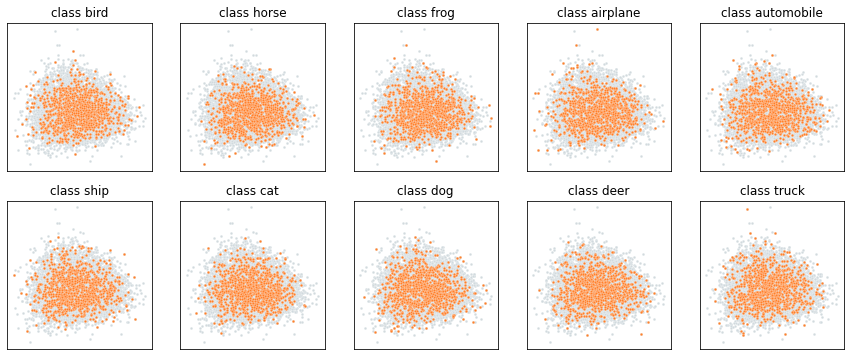

IDEC_RotNet_e100_features class representation


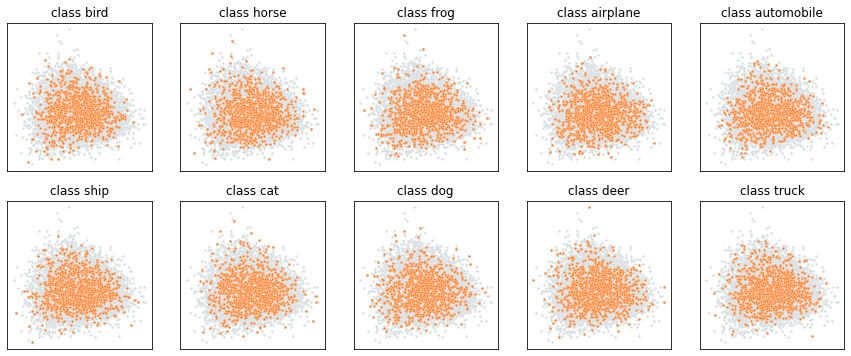

In [86]:
lc = np.array(lable_classes)

for ver in vers:
    print(f'{ver} class representation')
    fig, axes = plt.subplots(2,5, figsize=(15,6))
    axes = axes.flatten()

    for i, c in enumerate(set(lable_classes)):
        ids = np.where(lc==c)[0]
        axes[i].set(title=f'class {c}')
        axes[i].tick_params(bottom=False, left=False)
        axes[i].set(xticklabels=[], yticklabels=[])
        sns.scatterplot(ax=axes[i], x=pcas[ver][:,0], y=pcas[ver][:,1], s=7, color='#d1dade')  
        sns.scatterplot(ax=axes[i], x=pcas[ver][ids,0], y=pcas[ver][ids,1], s=7, color='#ff802b')

    plt.show()

### RotNet DEC

In [76]:
rotnet = idec_simclr
model = rotnet.model

embedded_data, labels = model.model.encode_batchwise(testloader, device, ['conv2'], flatten=True)
lable_classes=[colors_classes[l] for l in labels]

n_clusters = len(set(labels))
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(embedded_data)
nmis[ver] = normalized_mutual_info_score(labels, kmeans.labels_)

pca = PCA(n_components=2)
pcas[ver] = pca.fit_transform(embedded_data)

<AxesSubplot:title={'center':'IDEC_RotNet_e100_features Kmeans NMI: 0.2856'}>

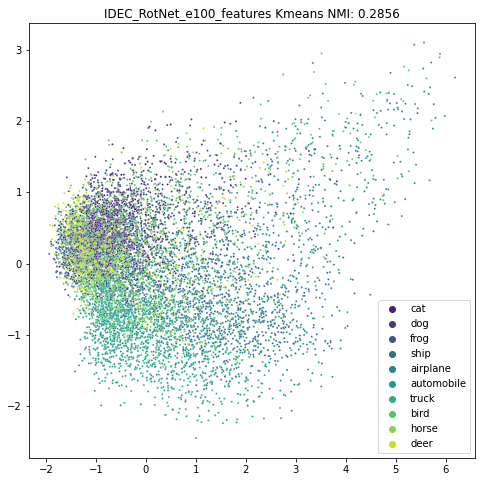

In [72]:
fig, axes = plt.subplots(figsize=(8,8))
axes.set_title(f'{ver} Kmeans NMI: {nmis[ver]:.4f}')
sns.scatterplot(ax=axes, x=pcas[ver][:,0], y=pcas[ver][:,1], hue=lable_classes, s=4, palette='viridis')

DEC_RotNet class representation


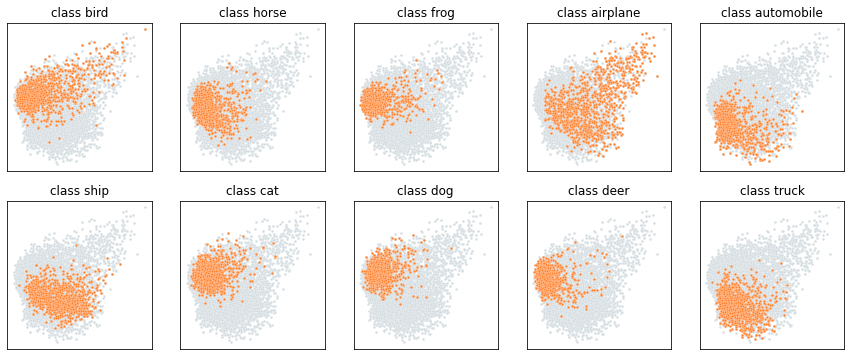

In [77]:
lc = np.array(lable_classes)
print(f'{ver} class representation')
fig, axes = plt.subplots(2,5, figsize=(15,6))
axes = axes.flatten()

for i, c in enumerate(set(lable_classes)):
    ids = np.where(lc==c)[0]
    axes[i].set(title=f'class {c}')
    axes[i].tick_params(bottom=False, left=False)
    axes[i].set(xticklabels=[], yticklabels=[])
    sns.scatterplot(ax=axes[i], x=pcas[ver][:,0], y=pcas[ver][:,1], s=7, color='#d1dade')  
    sns.scatterplot(ax=axes[i], x=pcas[ver][ids,0], y=pcas[ver][ids,1], s=7, color='#ff802b')

plt.show()

Here the clusters already look better! I have also tried to train a little bit longer, but it seems it was too much.

In [95]:
ver = 'DEC_RotNet_100'
print(ver)
if 'DEC' not in ver:
    rotnet = RotNet(num_classes=4)
else:
    rotnet = IDEC(model=RotNet(num_classes=4), cluster_centers=torch.rand(size=(4, 12288)))

state_dict = torch.load(f'trained_models/{ver}.pth', map_location=device)
rotnet.load_state_dict(state_dict)
rotnet.to(device)

if 'DEC' not in ver:
    model = rotnet
else:
    model = rotnet.model

embedded_data, labels = model.encode_batchwise(testloader, device, ['conv2'], flatten=True)
lable_classes=[colors_classes[l] for l in labels]

n_clusters = len(set(labels))
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(embedded_data)
nmis[ver] = normalized_mutual_info_score(labels, kmeans.labels_)

pca = PCA(n_components=2)
pcas[ver] = pca.fit_transform(embedded_data)

DEC_RotNet_100


D:\everything\Studium\WS2020\Bachelor\dcl_b\models\dec\DEC.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = torch.nn.Parameter(torch.tensor(init_np_centers), requires_grad=True)


<AxesSubplot:title={'center':'DEC_RotNet_100 Kmeans NMI: 0.2136'}>

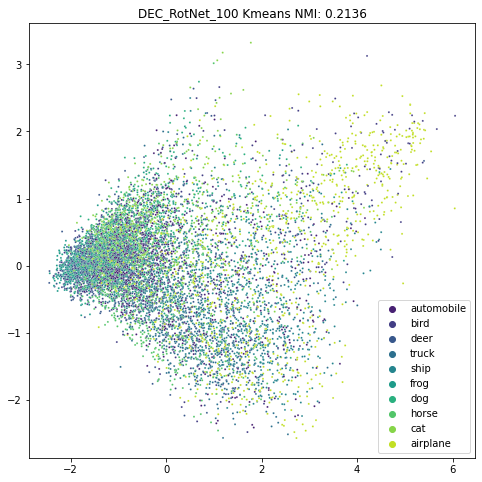

In [96]:
fig, axes = plt.subplots(figsize=(8,8))
axes.set_title(f'{ver} Kmeans NMI: {nmis[ver]:.4f}')
sns.scatterplot(ax=axes, x=pcas[ver][:,0], y=pcas[ver][:,1], hue=lable_classes, s=4, palette='viridis')

DEC_RotNet_100 class representation


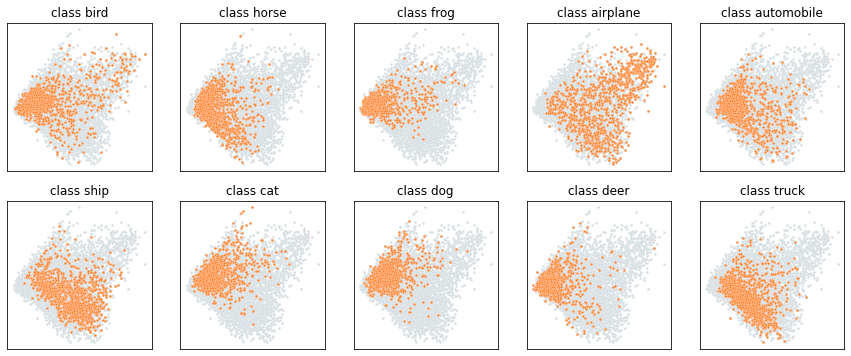

In [97]:
lc = np.array(lable_classes)
print(f'{ver} class representation')
fig, axes = plt.subplots(2,5, figsize=(15,6))
axes = axes.flatten()

for i, c in enumerate(set(lable_classes)):
    ids = np.where(lc==c)[0]
    axes[i].set(title=f'class {c}')
    axes[i].tick_params(bottom=False, left=False)
    axes[i].set(xticklabels=[], yticklabels=[])
    sns.scatterplot(ax=axes[i], x=pcas[ver][:,0], y=pcas[ver][:,1], s=7, color='#d1dade')  
    sns.scatterplot(ax=axes[i], x=pcas[ver][ids,0], y=pcas[ver][ids,1], s=7, color='#ff802b')

plt.show()